# 라이브러리 불러오기

In [6]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 랜덤 시드 설정

In [7]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [8]:
train_data = pd.read_csv("../../data/train.csv")
test_data = pd.read_csv("../../data/test.csv")
sample_submission = pd.read_csv("../../data/sample_submission.csv")

# 데이터 EDA 수행하기

In [9]:
# 데이터 크기와 컬럼 이름 확인
print(train_data.shape)
print(test_data.shape)
print(train_data.columns)
print(test_data.columns)

(1801228, 11)
(150172, 10)
Index(['index', 'area_m2', 'contract_year_month', 'contract_day',
       'contract_type', 'floor', 'built_year', 'latitude', 'longitude', 'age',
       'deposit'],
      dtype='object')
Index(['index', 'area_m2', 'contract_year_month', 'contract_day',
       'contract_type', 'floor', 'built_year', 'latitude', 'longitude', 'age'],
      dtype='object')


In [10]:
print("train, test_data, sample_submission shape : ", train_data.shape, test_data.shape, sample_submission.shape)
print("train data 상단 5개 정보 확인 : ", train_data.head())
print("test data 상단 5개 정보 확인 : ", test_data.head())
print("sample_submission 상단 5개 정보 확인 : ", sample_submission.head())
print("train data 변수 요약 정보 확인 : ", train_data.describe())
print("test data 변수 요약 정보 확인 : ", test_data.describe())

train, test_data, sample_submission shape :  (1801228, 11) (150172, 10) (150172, 2)
train data 상단 5개 정보 확인 :     index  area_m2  contract_year_month  contract_day  contract_type  floor  \
0      0  84.9981               201906            25              2      9   
1      1  84.9981               202003            26              2     20   
2      2  84.9981               202003            28              2      8   
3      3  59.3400               201907            15              2      1   
4      4  59.8100               201904            12              2      6   

   built_year   latitude   longitude  age  deposit  
0        2019  37.054314  127.045216    0  17000.0  
1        2019  37.054314  127.045216    1  23000.0  
2        2019  37.054314  127.045216    1  23000.0  
3        1986  36.964647  127.055847   33   5000.0  
4        1995  36.972390  127.084514   24   1800.0  
test data 상단 5개 정보 확인 :     index  area_m2  contract_year_month  contract_day  contract_type  floor  \


In [11]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
index,1801228.0,900613.500000,519969.879673,0.000000,450306.750000,900613.500000,1.350920e+06,1.801227e+06
area_m2,1801228.0,75.188332,25.526325,10.321500,59.750000,77.150000,8.496000e+01,3.173600e+02
contract_year_month,1801228.0,202133.126019,135.281455,201904.000000,202008.000000,202111.000000,2.022120e+05,2.023120e+05
contract_day,1801228.0,15.899430,8.625998,1.000000,9.000000,16.000000,2.300000e+01,3.100000e+01
contract_type,1801228.0,1.203805,0.885279,0.000000,0.000000,2.000000,2.000000e+00,2.000000e+00
floor,1801228.0,10.051971,6.973359,-4.000000,5.000000,9.000000,1.400000e+01,6.800000e+01
built_year,1801228.0,2004.198773,11.151317,1961.000000,1995.000000,2004.000000,2.015000e+03,2.024000e+03
latitude,1801228.0,37.477208,0.162511,36.917910,37.379762,37.502270,3.758205e+01,3.818194e+01
longitude,1801228.0,126.966233,0.170122,126.478708,126.842159,126.997594,1.270888e+02,1.276609e+02
age,1801228.0,17.065967,11.127956,-3.000000,7.000000,17.000000,2.600000e+01,6.200000e+01


In [12]:
small_house = train_data[(train_data['area_m2'] < 20)]

In [13]:
small_house.describe().T

,count,mean,std,min,25%,50%,75%,max
index,19814.0,1.051321e+06,451085.189281,592.000000,796671.250000,1.165044e+06,1.374726e+06,1.787731e+06
area_m2,19814.0,1.559150e+01,2.214456,10.321500,14.020000,1.512000e+01,1.730100e+01,1.999400e+01
contract_year_month,19814.0,2.021124e+05,126.204123,201904.000000,202007.000000,2.021070e+05,2.022070e+05,2.023120e+05
contract_day,19814.0,1.569168e+01,8.642257,1.000000,8.000000,1.600000e+01,2.300000e+01,3.100000e+01
contract_type,19814.0,1.305642e+00,0.897993,0.000000,0.000000,2.000000e+00,2.000000e+00,2.000000e+00
floor,19814.0,9.188453e+00,4.603933,1.000000,6.000000,9.000000e+00,1.200000e+01,2.900000e+01
built_year,19814.0,2.015726e+03,3.769708,1970.000000,2013.000000,2.015000e+03,2.019000e+03,2.023000e+03
latitude,19814.0,3.750702e+01,0.144274,36.989058,37.482729,3.753034e+01,3.757353e+01,3.790467e+01
longitude,19814.0,1.269832e+02,0.122940,126.606298,126.908060,1.270233e+02,1.270724e+02,1.276502e+02
age,19814.0,5.333703e+00,3.850219,-1.000000,2.000000,6.000000e+00,8.000000e+00,5.200000e+01


In [14]:
train_data[
    (np.isclose(train_data['longitude'], 127.267601, atol=1e-5)) & 
    (np.isclose(train_data['latitude'], 37.013363, atol=1e-5))
]

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
65540,65540,38.52,201906,4,2,3,1987,37.013363,127.267601,32,4000.0
65543,65543,38.52,201906,24,2,5,1987,37.013363,127.267601,32,3000.0
65544,65544,38.52,201906,29,2,4,1987,37.013363,127.267601,32,4000.0
65545,65545,38.52,201907,13,2,1,1987,37.013363,127.267601,32,3000.0
65547,65547,38.52,201910,11,2,5,1987,37.013363,127.267601,32,3500.0
...,...,...,...,...,...,...,...,...,...,...,...
844998,844998,38.52,202311,9,2,5,1987,37.013363,127.267601,36,8000.0
844999,844999,38.52,202311,12,1,5,1987,37.013363,127.267601,36,8000.0
845000,845000,47.25,202312,5,1,5,1987,37.013363,127.267601,36,9500.0
845001,845001,38.52,202312,18,1,5,1987,37.013363,127.267601,36,7850.0


In [15]:
train_data[
    (np.isclose(train_data['longitude'], 127.267601, atol=1e-5)) & 
    (np.isclose(train_data['latitude'], 37.013363, atol=1e-5))
].describe().T

,count,mean,std,min,25%,50%,75%,max
index,115.0,493262.530435,2.333132e+05,65540.000000,328626.500000,424094.000000,645286.500000,845002.000000
area_m2,115.0,41.101043,4.001242e+00,38.520000,38.520000,38.520000,47.250000,47.250000
contract_year_month,115.0,202157.921739,1.145233e+02,201906.000000,202103.500000,202201.000000,202212.000000,202312.000000
contract_day,115.0,16.060870,8.527856e+00,1.000000,9.000000,17.000000,23.000000,31.000000
contract_type,115.0,0.982609,9.641159e-01,0.000000,0.000000,1.000000,2.000000,2.000000
floor,115.0,3.695652,1.325684e+00,1.000000,3.000000,4.000000,5.000000,5.000000
built_year,115.0,1987.000000,0.000000e+00,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000
latitude,115.0,37.013363,1.427305e-14,37.013363,37.013363,37.013363,37.013363,37.013363
longitude,115.0,127.267601,0.000000e+00,127.267601,127.267601,127.267601,127.267601,127.267601
age,115.0,34.513043,1.149868e+00,32.000000,34.000000,35.000000,35.000000,36.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x7f6c7f997a60>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6c7f997fa0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6c7f9977c0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f6c7f794520>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f6c7f7947c0>],
 'means': []}

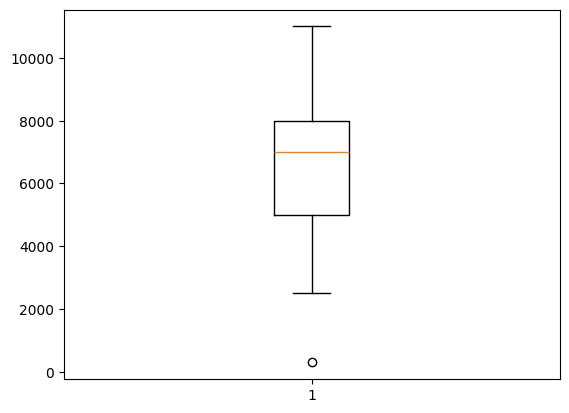

In [16]:
import matplotlib.pyplot as plt
import numpy as np
plt.boxplot(train_data[
    (np.isclose(train_data['longitude'], 127.267601, atol=1e-5)) & 
    (np.isclose(train_data['latitude'], 37.013363, atol=1e-5))
]['deposit'])

In [17]:
train_data[(train_data['deposit'] <= 500)]

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
45975,45975,25.0400,201910,9,2,2,1997,37.355282,126.717520,22,500.0
62174,62174,17.8919,202001,29,2,3,2013,37.755771,126.779882,7,500.0
62223,62223,15.7838,202002,15,2,10,2013,37.755771,126.779882,7,500.0
65548,65548,47.2500,201910,22,2,5,1987,37.013363,127.267601,32,300.0
94595,94595,39.7200,202002,17,2,4,1986,37.323651,126.836041,34,500.0
109371,109371,18.3500,201908,9,2,8,2016,37.398070,126.924832,3,500.0
170048,170048,39.9600,202102,15,2,5,1988,37.688166,127.210332,33,500.0
173339,173339,35.2800,202006,8,2,2,1999,37.003774,127.224924,21,500.0
178894,178894,59.9400,202102,6,2,1,1997,37.827964,127.137864,24,500.0
193026,193026,17.1800,202101,20,2,15,2018,36.993903,127.088089,3,500.0


In [18]:
something_small_area=train_data[
    (train_data['longitude'] == 127.0880887) & 
    (train_data['latitude'] == 36.993903)
]

In [19]:
something_small_area.describe().T

,count,mean,std,min,25%,50%,75%,max
index,120.0,362188.758333,2.263987e+05,27782.000000,193004.750000,371629.500000,590841.250000,806023.000000
area_m2,120.0,17.248667,2.580044e-01,17.180000,17.180000,17.180000,17.180000,18.210000
contract_year_month,120.0,202111.875000,1.257348e+02,201906.000000,202007.000000,202107.500000,202208.000000,202311.000000
contract_day,120.0,14.591667,8.206880e+00,1.000000,7.000000,14.000000,21.000000,31.000000
contract_type,120.0,1.008333,9.657655e-01,0.000000,0.000000,1.000000,2.000000,2.000000
floor,120.0,10.225000,3.637948e+00,4.000000,7.000000,11.000000,13.000000,16.000000
built_year,120.0,2018.000000,0.000000e+00,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000
latitude,120.0,36.993903,0.000000e+00,36.993903,36.993903,36.993903,36.993903,36.993903
longitude,120.0,127.088089,2.854088e-14,127.088089,127.088089,127.088089,127.088089,127.088089
age,120.0,3.050000,1.269222e+00,1.000000,2.000000,3.000000,4.000000,5.000000


In [20]:
something_small_area[something_small_area["floor"]==6]

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
27797,27797,17.18,201909,22,2,6,2018,36.993903,127.088089,1,6500.0
193003,193003,17.18,202007,17,2,6,2018,36.993903,127.088089,2,7000.0
193004,193004,17.18,202007,17,2,6,2018,36.993903,127.088089,2,7000.0
371636,371636,17.18,202110,4,0,6,2018,36.993903,127.088089,3,9800.0
590833,590833,17.18,202205,18,0,6,2018,36.993903,127.088089,4,8000.0
590844,590844,17.18,202210,10,0,6,2018,36.993903,127.088089,4,11700.0
590854,590854,17.18,202301,2,0,6,2018,36.993903,127.088089,5,11000.0
590858,590858,17.18,202302,13,0,6,2018,36.993903,127.088089,5,11000.0
590859,590859,17.18,202302,14,0,6,2018,36.993903,127.088089,5,11000.0
590860,590860,17.18,202302,14,0,6,2018,36.993903,127.088089,5,11000.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f6c7f8439d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6c7f843f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6c7f843730>],
 'medians': [<matplotlib.lines.Line2D at 0x7f6c7d684490>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f6c7d684730>],
 'means': []}

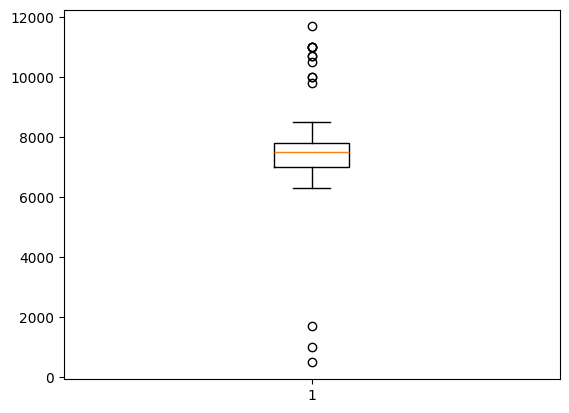

In [21]:
import matplotlib.pyplot as plt
import numpy as np
plt.boxplot(train_data[
    (train_data['longitude'] == 127.0880887) & 
    (train_data['latitude'] == 36.993903)
]['deposit'])

In [22]:
something_small_area=train_data[
    (np.isclose(train_data['longitude'], 127.088089, atol=1e-100)) & 
    (np.isclose(train_data['latitude'], 36.993903, atol=1e-100))
]

In [23]:
something_small_area

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
27777,27777,19.92,201905,7,2,4,2019,36.994057,127.088417,0,8000.0
27782,27782,17.18,201906,2,2,8,2018,36.993903,127.088089,1,7000.0
27786,27786,17.18,201907,19,2,13,2018,36.993903,127.088089,1,7500.0
27788,27788,17.18,201907,24,2,15,2018,36.993903,127.088089,1,7500.0
27789,27789,17.18,201907,31,2,15,2018,36.993903,127.088089,1,7500.0
...,...,...,...,...,...,...,...,...,...,...,...
806019,806019,17.18,202306,14,1,7,2018,36.993903,127.088089,5,7500.0
806020,806020,17.18,202306,14,0,13,2018,36.993903,127.088089,5,7800.0
806021,806021,17.18,202307,17,1,8,2018,36.993903,127.088089,5,7500.0
806022,806022,17.18,202309,6,0,4,2018,36.993903,127.088089,5,7000.0


In [24]:
something_small_area["longitude"].unique()

array([127.0884171, 127.0880887])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6c7d6c7250>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6c7d6c7790>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6c7d6c6fb0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f6c7d6c7cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f6c7d6c7f70>],
 'means': []}

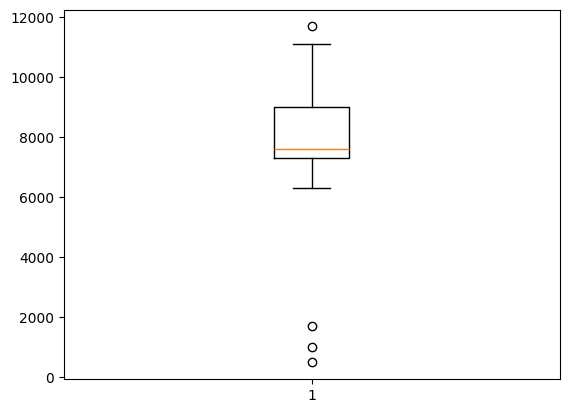

In [25]:
import matplotlib.pyplot as plt
import numpy as np
plt.boxplot(train_data[
    (np.isclose(train_data['longitude'], 127.088089, atol=1e-5)) & 
    (np.isclose(train_data['latitude'], 36.993903, atol=1e-5))
]['deposit'])

In [26]:
min(train_data['latitude'])

36.9179099

In [27]:
train_data[(train_data['latitude'] == max(train_data['latitude']))]

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
14694,14694,83.27,201910,16,2,1,1998,38.181937,127.105145,21,2500.0


In [28]:
train_data[(train_data['age'] == -3)]

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
31588,31588,112.86,201906,10,2,5,2022,37.428620,126.998875,-3,146900.0
445834,445834,84.95,202109,7,0,16,2024,37.816934,127.056850,-3,26000.0
987149,987149,84.72,201907,20,2,1,2022,37.595555,126.923904,-3,16100.0
1112268,1112268,84.99,202012,1,2,6,2023,37.538617,127.082375,-3,80000.0


In [29]:
train_data[(train_data['longitude'] == 127.056850) & (train_data['latitude'] == 37.816934)]

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit


In [30]:
train_data[
    (np.isclose(train_data['longitude'], 127.056850, atol=1e-5)) & 
    (np.isclose(train_data['latitude'], 37.816934, atol=1e-5))
]

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
445834,445834,84.95,202109,7,0,16,2024,37.816934,127.05685,-3,26000.0
863548,863548,84.95,202312,16,0,20,2024,37.816934,127.05685,-1,22500.0
863549,863549,74.97,202312,18,0,12,2024,37.816934,127.05685,-1,22000.0
863550,863550,74.97,202312,25,0,7,2024,37.816934,127.05685,-1,21000.0
863551,863551,84.97,202312,30,0,9,2024,37.816934,127.05685,-1,26000.0


In [31]:
import matplotlib.pyplot as plt

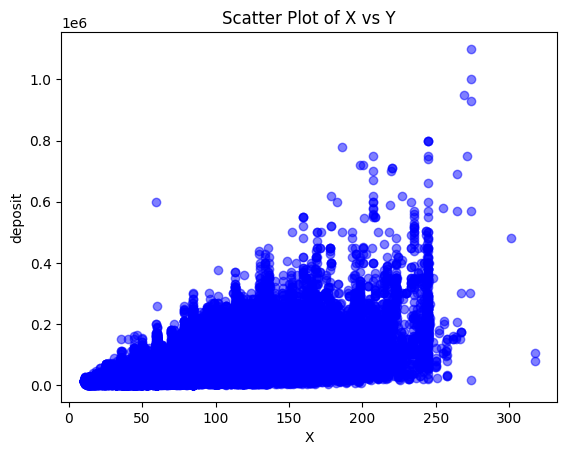

In [32]:
import matplotlib.pyplot as plt

# X와 Y 변수의 산점도
plt.scatter(train_data['area_m2'], train_data['deposit'], alpha=0.5, color='blue')
plt.title('Scatter Plot of X vs Y')
plt.xlabel('X')
plt.ylabel('deposit')
plt.show()

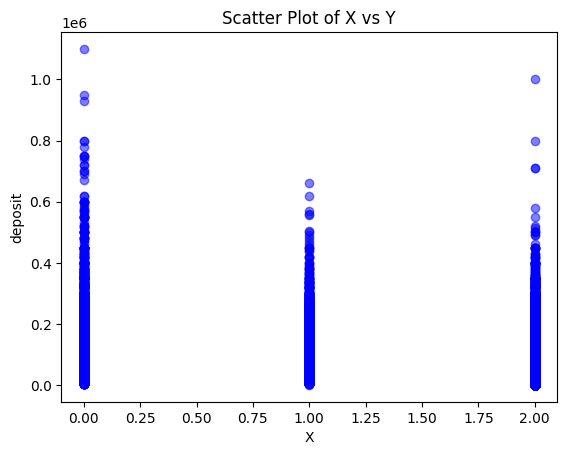

In [33]:
# X와 Y 변수의 산점도
plt.scatter(train_data['contract_type'], train_data['deposit'], alpha=0.5, color='blue')
plt.title('Scatter Plot of X vs Y')
plt.xlabel('X')
plt.ylabel('deposit')
plt.show()

In [34]:
print(train_data[train_data["contract_type"]==0]["deposit"].median())
print(train_data[train_data["contract_type"]==0]["deposit"].mean())
print(train_data[train_data["contract_type"]==1]["deposit"].median())
print(train_data[train_data["contract_type"]==1]["deposit"].mean())
print(train_data[train_data["contract_type"]==2]["deposit"].median())
print(train_data[train_data["contract_type"]==2]["deposit"].mean())

34000.0
40414.873475710534
35000.0
41508.277431653194
30000.0
35665.470805558136


In [35]:
import scipy.stats as stats


# t-검정 수행
t_stat, p_value = stats.ttest_ind(train_data[train_data["contract_type"]==0]["deposit"], train_data[train_data["contract_type"]==1]["deposit"])

print(f't-통계량: {t_stat}, p-값: {p_value}')

t-통계량: -17.805717942352004, p-값: 6.568048143997928e-71


In [36]:
train_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0
...,...,...,...,...,...,...,...,...,...,...,...
1801223,1801223,114.8126,202311,25,0,5,2010,37.528394,126.659398,13,39000.0
1801224,1801224,101.9088,202311,28,0,6,2010,37.528394,126.659398,13,38000.0
1801225,1801225,114.7900,202312,3,0,19,2010,37.528394,126.659398,13,37000.0
1801226,1801226,101.9088,202312,4,1,15,2010,37.528394,126.659398,13,34400.0


# 대회에 필요한 데이터만 활용하기

In [37]:
columns_needed = ['area_m2', 'contract_year_month', 'contract_day', 'contract_type', 'floor', 'latitude', 'longitude', 'deposit']
columns_needed_test = ['area_m2', 'contract_year_month', 'contract_day', 'contract_type', 'floor', 'latitude', 'longitude']
train_data = train_data[columns_needed]
test_data = test_data[columns_needed_test]

# Holdout 데이터셋 설정 (예: 2023년 7월부터 12월까지의 데이터)

In [38]:
holdout_start = 202307
holdout_end = 202312
holdout_data = train_data[(train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end)]
train_data = train_data[~((train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end))]

In [39]:
'''
for i in range(301):
    n = i
    filtered_df = train_data.groupby('latitude').filter(lambda x: len(x) > n)
    filtered_df1 = filtered_df.groupby('longitude').filter(lambda x: len(x) > n)

    X_train = filtered_df1.drop(columns=['deposit'])
    y_train = filtered_df1['deposit']
    X_holdout = holdout_data.drop(columns=['deposit'])
    y_holdout = holdout_data['deposit']
    X_test = test_data.copy()

    lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
    lgb_model.fit(X_train, y_train)

    lgb_holdout_pred = lgb_model.predict(X_holdout)
    lgb_holdout_mae = mean_absolute_error(y_holdout, lgb_holdout_pred)

    test_list.append(f"{lgb_holdout_mae:.4f}")
    '''

'\nfor i in range(301):\n    n = i\n    filtered_df = train_data.groupby(\'latitude\').filter(lambda x: len(x) > n)\n    filtered_df1 = filtered_df.groupby(\'longitude\').filter(lambda x: len(x) > n)\n\n    X_train = filtered_df1.drop(columns=[\'deposit\'])\n    y_train = filtered_df1[\'deposit\']\n    X_holdout = holdout_data.drop(columns=[\'deposit\'])\n    y_holdout = holdout_data[\'deposit\']\n    X_test = test_data.copy()\n\n    lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)\n    lgb_model.fit(X_train, y_train)\n\n    lgb_holdout_pred = lgb_model.predict(X_holdout)\n    lgb_holdout_mae = mean_absolute_error(y_holdout, lgb_holdout_pred)\n\n    test_list.append(f"{lgb_holdout_mae:.4f}")\n    '

In [40]:
'''
for i in [1,3,5]:
    n = i
    filtered_df = train_data.groupby('latitude').filter(lambda x: len(x) != n)
    train_data = filtered_df.groupby('longitude').filter(lambda x: len(x) != n)
'''

"\nfor i in [1,3,5]:\n    n = i\n    filtered_df = train_data.groupby('latitude').filter(lambda x: len(x) != n)\n    train_data = filtered_df.groupby('longitude').filter(lambda x: len(x) != n)\n"

In [41]:
# 각 위도별 개수를 세고, 개수가 n 이상인 것만 필터링합니다.
n = 49
filtered_df = train_data.groupby('latitude').filter(lambda x: len(x) > n)
train_data = filtered_df.groupby('longitude').filter(lambda x: len(x) > n)
print(len(train_data))


1446685


# 학습 데이터와 정답 데이터 분리

In [42]:
X_train = train_data.drop(columns=['deposit'])
y_train = train_data['deposit']
X_holdout = holdout_data.drop(columns=['deposit'])
y_holdout = holdout_data['deposit']
X_test = test_data.copy()

# LightGBM 모델 훈련

In [43]:
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 914
[LightGBM] [Info] Number of data points in the train set: 1446685, number of used features: 7
[LightGBM] [Info] Start training from score 38342.933263


LGBMRegressor(random_state=42)

# Holdout 데이터셋에 대한 성능 확인

In [44]:
lgb_holdout_pred = lgb_model.predict(X_holdout)
lgb_holdout_mae = mean_absolute_error(y_holdout, lgb_holdout_pred)
print("Holdout 데이터셋 성능:")
print(f"LightGBM MAE: {lgb_holdout_mae:.2f}")

Holdout 데이터셋 성능:
LightGBM MAE: 7769.36


# Sample Submission 제출하기

In [45]:
lgb_test_pred = lgb_model.predict(X_test)
sample_submission['deposit'] = lgb_test_pred
sample_submission.to_csv('output.csv', index=False, encoding='utf-8-sig')